# Delta Performances Part 1

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the CAMELS data

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Read all predictions

In [7]:
from scripts.drafts.io_results import read_ensemble_results, read_fuse_data
from scripts.drafts.calculate_error_scores import DeltaError
SAVE = True
RELOAD = False

if RELOAD:
    pet_ealstm_ensemble_dir = data_dir / "runs/ensemble_pet_ealstm"
    ealstm_preds = read_ensemble_results(pet_ealstm_ensemble_dir)

    lstm_ensemble_dir = data_dir / "runs/ensemble_pet"
    lstm_preds = read_ensemble_results(lstm_ensemble_dir)

    raw_fuse_path = data_dir / "RUNOFF/FUSE"
    fuse_data = read_fuse_data(raw_fuse_path, lstm_preds["obs"])

    # get matching stations
    all_stations_lstm = np.isin(lstm_preds.station_id, fuse_data.station_id)
    all_stations_ealstm = np.isin(ealstm_preds.station_id, fuse_data.station_id)
    lstm_preds = lstm_preds.sel(
        station_id=all_stations_lstm, time=np.isin(lstm_preds.time, fuse_data.time)
    )
    ealstm_preds = ealstm_preds.sel(
        station_id=all_stations_ealstm, time=np.isin(ealstm_preds.time, fuse_data.time)
    )

    processor = DeltaError(
        ealstm_preds,
        lstm_preds,
        fuse_data,
        benchmark_calculation_ds=ds[["discharge_spec"]],
        incl_benchmarks=True,
    )
    all_preds = processor.all_preds
    
    if SAVE:
        all_preds.to_netcdf(data_dir / "RUNOFF/all_preds.nc")

else:
    all_preds = xr.open_dataset(data_dir / "RUNOFF/all_preds.nc")
    
all_preds

<xarray.Dataset>
Dimensions:          (station_id: 518, time: 4018)
Coordinates:
  * time             (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2008-12-31
  * station_id       (station_id) int64 1001 2001 2002 ... 101005 102001 106001
Data variables:
    TOPMODEL         (station_id, time) float64 ...
    ARNOVIC          (station_id, time) float64 ...
    PRMS             (station_id, time) float64 ...
    SACRAMENTO       (station_id, time) float64 ...
    EALSTM           (station_id, time) float64 ...
    obs              (station_id, time) float64 ...
    LSTM             (station_id, time) float64 ...
    persistence      (time, station_id) float64 ...
    climatology_doy  (time, station_id) float64 ...
    climatology_mon  (time, station_id) float64 ...

In [8]:
import pickle
from scripts.drafts.calculate_error_scores import calculate_all_data_errors, get_metric_dataframes_from_output_dict

RELOAD = False

if RELOAD:
    all_errors = calculate_all_data_errors(all_preds, decompose_kge=True)
    all_metrics = get_metric_dataframes_from_output_dict(all_errors)
    if SAVE:
        pickle.dump(all_errors, (data_dir / "RUNOFF/all_errors.pkl").open("wb"))
        pickle.dump(all_metrics, (data_dir / "RUNOFF/all_metrics.pkl").open("wb"))
    
else:
    all_errors = pickle.load((data_dir / "RUNOFF/all_errors.pkl").open("rb"))
    all_metrics = pickle.load((data_dir / "RUNOFF/all_metrics.pkl").open("rb"))
    
all_metrics.keys()

all_metrics["bias_error_pct"] = all_metrics["bias_error"] * 100
all_metrics["std_error_pct"] = all_metrics["std_error"] * 100

all_metrics.keys()

dict_keys(['nse', 'kge', 'mse', 'bias', 'pbias', 'log_nse', 'inv_kge', 'sqrt_kge', 'abs_pct_bias', 'mape', 'bias_error', 'std_error', 'mam30_ape', 'rmse', 'correlation', 'bias_ratio', 'variability_ratio', 'inv_correlation', 'inv_bias_ratio', 'inv_variability_ratio', 'sqrt_correlation', 'sqrt_bias_ratio', 'sqrt_variability_ratio', 'bias_error_pct', 'std_error_pct'])

# Delta Errors

In [9]:
from scripts.drafts.calculate_error_scores import calculate_all_delta_dfs, calculate_error_diff

In [10]:
lstm_delta, ealstm_delta = calculate_all_delta_dfs(all_metrics)

# Ignore the benchmark models
models = ["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]
for metric in lstm_delta.keys():
    lstm_delta[metric] = lstm_delta[metric].loc[:, models + ["EALSTM"]]
    ealstm_delta[metric] = ealstm_delta[metric].loc[:, models + ["LSTM"]]

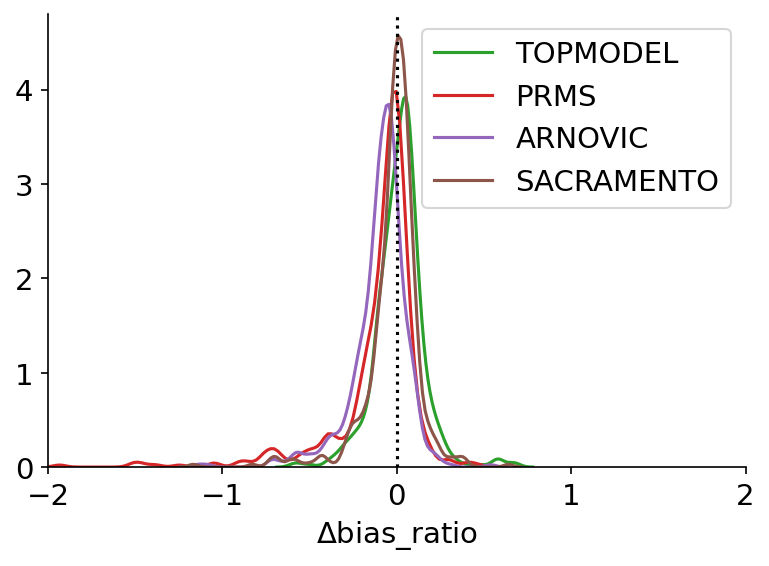

In [11]:
from typing import Tuple

color_lookup = {
    m: sns.color_palette()[2:][ix] for (ix, m) in enumerate(["TOPMODEL", "PRMS", "ARNOVIC", "SACRAMENTO"])
}

def kde_plot_deltas(delta_df: pd.DataFrame, metric: str = "nse", xlim: Tuple[float] = (-1, 1), ax=None):
        kde_kws = {"clip": xlim}
        hist_kws = {"range": xlim, "density": True}
        if ax is None:
            f, ax = plt.subplots()
        [
            sns.distplot(delta_df[c], ax=ax, kde_kws=kde_kws, hist_kws=hist_kws, hist=False, label=c, color=color_lookup[c])
            for c in ["TOPMODEL", "PRMS", "ARNOVIC", "SACRAMENTO"]
        ]
        ax.set_xlim(xlim)
        ax.axvline(0, ls=":", color="k")
        ax.set_xlabel(f"$\Delta${metric}")
        ax.legend()
        sns.despine()


metric = "bias_ratio"
kde_plot_deltas(lstm_delta[metric], metric=metric, xlim=(-2, 2))

# By region

In [12]:
import geopandas as gpd

hydro_regions = gpd.read_file(data_dir / "RUNOFF/gis_data_Tommy" / "UK_hydroclimate_regions_Harrigan_et_al_2018/UK_Hydro_Regions_ESP_HESS.shp").to_crs(epsg=4326)
hydro_regions = hydro_regions.loc[~np.isin(hydro_regions["NAME"], ["Northern Ireland", "Republic of Ireland"])]


region_abbrs = {
    'Western Scotland': "WS",
    'Eastern Scotland': "ES",
    'North-east England': "NEE",
    'Severn-Trent': "ST",
    'Anglian': "ANG",
    'Southern England': "SE",
    'South-west England & South Wales': "SWESW",
    'North-west England & North Wales (NWENW)': "NWENW",
}

def get_region_station_within(stations: gpd.GeoDataFrame, hydro_regions: gpd.GeoDataFrame):
    # find the region that a station belongs WITHIN
    # create a list of strings/nans for each station 
    region_dict = {}
    for region, geom in zip(hydro_regions["NAME"], hydro_regions["geometry"]):
        isin_region = ([p.within(geom) for p in stations])
        region_dict[region] = [(region if item else np.nan) for item in isin_region]

    region_cols = pd.DataFrame(region_dict)

    # copy non-null values from the right column into the left and select left
    # https://stackoverflow.com/a/49908660
    regions_list = (region_cols.bfill(axis=1).iloc[:, 0]).rename("region")
    regions_list.index = points.index

    return regions_list

In [13]:
d = static[["gauge_lat", "gauge_lon"]].to_dataframe()
points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
points.name = "geometry"

regions_list = get_region_station_within(points, hydro_regions)
all_points = gpd.GeoDataFrame(points).join(regions_list)

In [14]:
delta_nse = calculate_error_diff(all_metrics["nse"], ref_model="LSTM")[["TOPMODEL", "PRMS", "ARNOVIC", "SACRAMENTO"]]
delta_corr = calculate_error_diff(all_metrics["correlation"], ref_model="LSTM")[["TOPMODEL", "PRMS", "ARNOVIC", "SACRAMENTO"]]
delta_bias = calculate_error_diff(all_metrics["bias_error"], ref_model="LSTM")[["TOPMODEL", "PRMS", "ARNOVIC", "SACRAMENTO"]]
delta_bias = calculate_error_diff(all_metrics["std_error"], ref_model="LSTM")[["TOPMODEL", "PRMS", "ARNOVIC", "SACRAMENTO"]]

# gpd.GeoDataFrame(delta_nse.join(all_points)).plot("SACRAMENTO", vmin=0, vmax=0.2, cmap="viridis_r", markersize=6)
# gpd.GeoDataFrame(delta_nse.join(all_points)).plot("TOPMODEL", vmin=0, vmax=0.2, cmap="viridis_r", markersize=6)

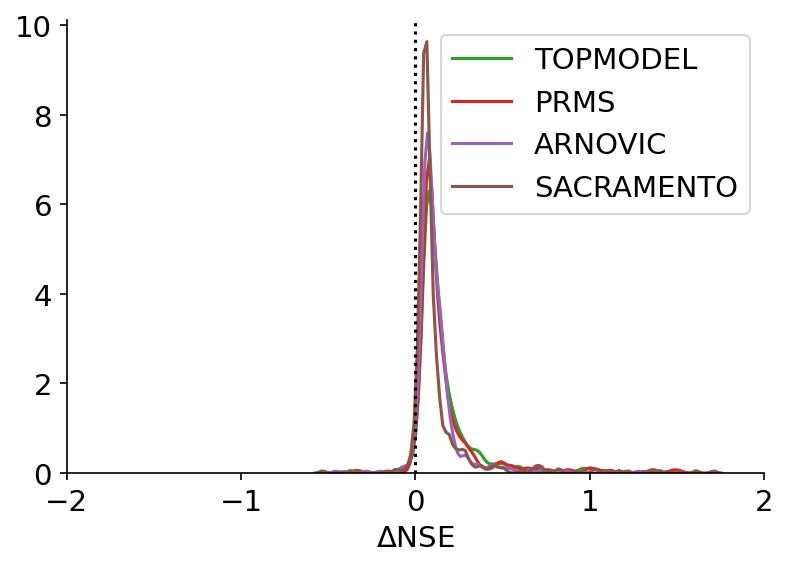

In [15]:
kde_plot_deltas(delta_nse, metric="NSE", xlim=(-2, 2))

# Seasonal Errors

In [16]:
# from typing import Dict, DefaultDict
# DefaultDict[str, Dict[str, pd.DataFrame]]

In [17]:
from scripts.drafts.calculate_error_scores import calculate_seasonal_errors

In [19]:
import pickle

if not (data_dir / "RUNOFF/seasonal_errors.pkl").exists():
    seasonal_errors = calculate_seasonal_errors(all_preds)
    pickle.dump(
        seasonal_errors, (data_dir / "RUNOFF/seasonal_errors.pkl").open("wb")
    )

else:
    seasonal_errors = pickle.load((data_dir / "RUNOFF/seasonal_errors.pkl").open("rb"))

In [20]:
seasonal_deltas = defaultdict(dict)
for season in ["DJF", "MAM", "JJA", "SON"]:
    seasonal_models = get_metric_dataframes_from_output_dict(seasonal_errors[season])
    seasonal_deltas[season]["LSTM"], seasonal_deltas[season]["EALSTM"] = calculate_all_delta_dfs(seasonal_models)

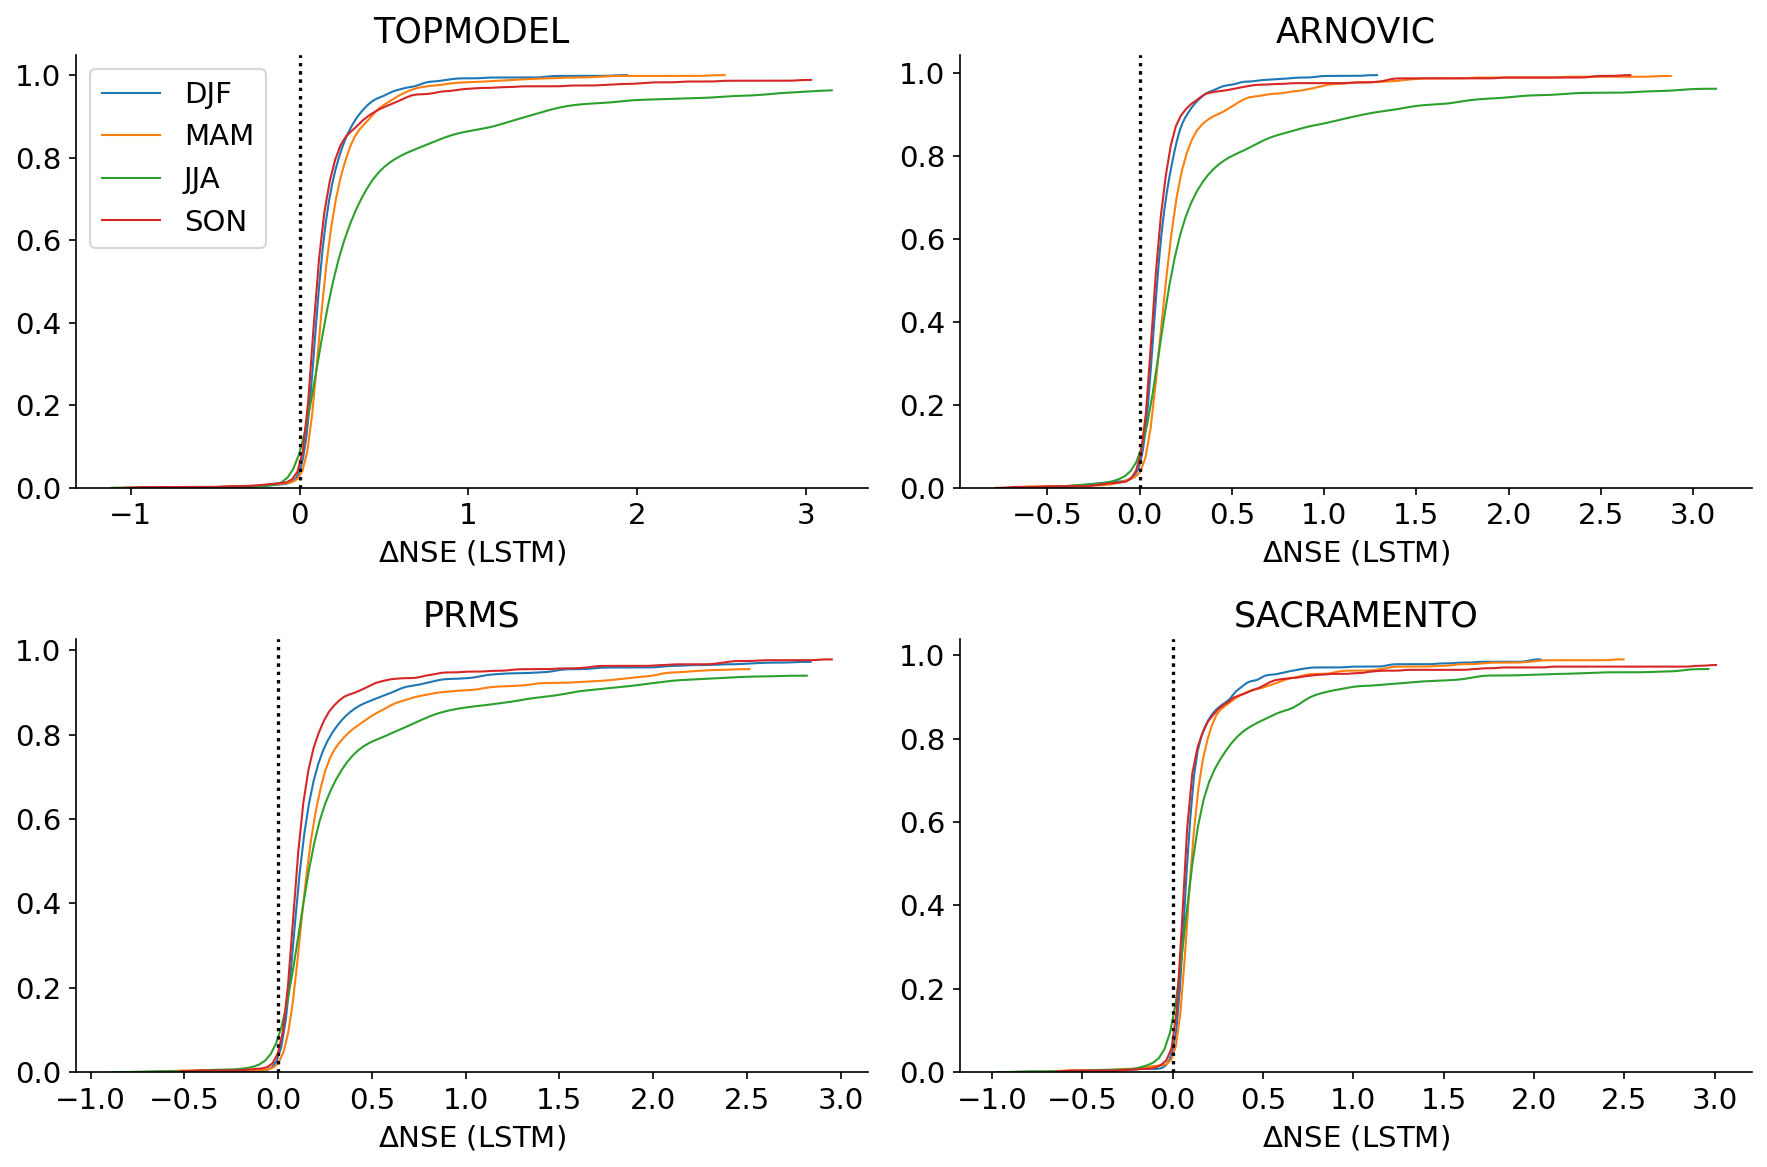

In [21]:
from typing import DefaultDict

# LSTM
metric = "nse"
ref_model = "LSTM"

def plot_seasonal_ecdfs(seasonal_deltas: DefaultDict, metric: str = "nse", ref_model: str = "LSTM", clip: Tuple[float] = (-1, 3)):
    fig, axs = plt.subplots(2, 2, figsize=(6*2, 4*2))

    for ix, model in enumerate(["TOPMODEL", "ARNOVIC", "PRMS", "SACRAMENTO"]):
        ax = axs[np.unravel_index(ix, (2, 2))]
        for season in ["DJF", "MAM", "JJA", "SON"]:
            sns.distplot(
                seasonal_deltas[season][ref_model][metric].loc[:, model].dropna(), 
                label=season, 
                kde_kws = {"clip": (-1, 3), "linewidth":1, "cumulative": True}, 
                hist=False, ax=ax
            )

            ax.axvline(0, ls=":", color="k", alpha=0.6)
            ax.set_xlabel(f"$\Delta${metric.upper()} ({ref_model})")
            ax.set_title(model)
            if ix != 0:
                ax.get_legend().remove()

            sns.despine()

    plt.tight_layout()
    
plot_seasonal_ecdfs(seasonal_deltas, metric="nse", ref_model="LSTM")